# Data processing: step 3

Make cuts on the events, define a signal region, split into train-test, preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *


In [2]:
codes_list = ["wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full","cmssim","wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full", "od"]

#codes_list = ["cmssim"]
uncut_data = {}
for code in codes_list:
    uncut_data[code] = np.load(f"compiled_data/{code}.npy")
    uncut_data[code] = np.nan_to_num(uncut_data[code])
    print(f"{code} has initial shape {uncut_data[code].shape}")

wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full has initial shape (6755, 13)
cmssim has initial shape (7433462, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full has initial shape (5653, 13)
od has initial shape (1957364, 13)


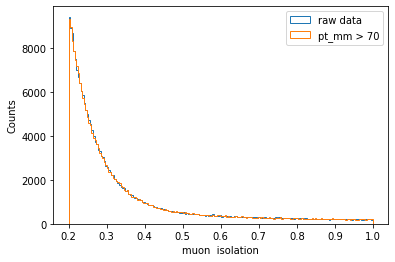

(1957364,)


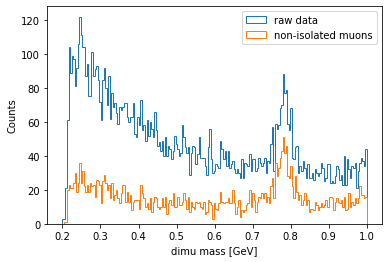

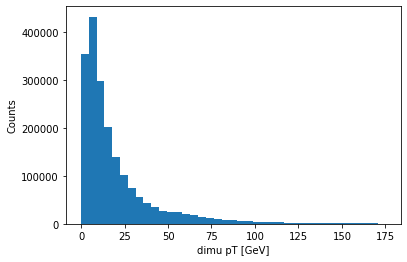

In [11]:
loc_m_mumu = uncut_data["od"][:,-1]
loc_pt_mumu = uncut_data["od"][:,-4]
loc_iso_mu = uncut_data["od"][:,5]
loc_iso_amu = uncut_data["od"][:,7]

plt.figure()
plt.hist(loc_iso_mu, bins = np.linspace(0.2, 1, 200), histtype = "step", label = "raw data")
plt.hist(loc_iso_amu, bins = np.linspace(0.2, 1, 200), histtype = "step", label = "pt_mm > 70")
plt.legend()
plt.xlabel("muon  isolation")
plt.ylabel("Counts")
plt.show()


eta_mass = 0.547862 # GeV

print(loc_m_mumu.shape)
iso_cutoff = 0.6
passes = (loc_iso_mu > iso_cutoff) & (loc_iso_amu > iso_cutoff)

plt.figure()
plt.hist(loc_m_mumu, bins = np.linspace(0.2, 1, 200), histtype = "step", label = "raw data")
plt.hist(loc_m_mumu[passes], bins = np.linspace(0.2, 1, 200), histtype = "step", label = "non-isolated muons")
plt.legend()
plt.xlabel("dimu mass [GeV]")
plt.ylabel("Counts")
plt.show()

plt.figure()
plt.hist(loc_pt_mumu, bins = np.linspace(0, 175, 40))
plt.xlabel("dimu pT [GeV]")
plt.ylabel("Counts")
plt.show()



## Visualize the data

In [ ]:
feature_set = [9, 10, 12]
    
hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype)
    


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [ ]:
# jet_cuts

jet_pt_cut = 0 
jet_eta_cut = 10000

cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    pass_indices = (uncut_data[code][:,0] > jet_pt_cut) & (np.abs(uncut_data[code][:,1]) < jet_eta_cut) # MAKE SURE THE INDICES ARE OK
    cut_data[code] = uncut_data[code][pass_indices]
    print(f"{code} has shape {cut_data[code].shape} after cuts")
    

In [ ]:
    
    
hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype, image_path = "plots/sim_v_od")
    

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

In [ ]:
band_bounds = {"SBL": [15, 35],
               "IBL": [35, 40],
               "SR": [40, 60],
               "IBH": [60, 65],
               "SBH": [65, 80],
                       }

In [ ]:
plt.figure()

for code in codes_list:
    plt.hist(cut_data[code][:,-1], bins = np.linspace(15, 120, 100), histtype = "step", density = "True", label = code)

plt.legend()
plt.axvline(band_bounds["SBL"][0], color= "red")
plt.axvline(band_bounds["IBL"][0], color= "red")
plt.axvline(band_bounds["SR"][0], color= "red")
plt.axvline(band_bounds["IBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][1], color= "red")

plt.xlabel("$M_{\mu\mu}$")

plt.xlim(0, 110)
plt.yscale("log")
plt.show()

In [ ]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
IBL_data_preprocc = {} # innerband low
IBH_data_preprocc = {} # innerband high

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]

preproc_dicts = {b:{} for b in bands}


for code in codes_list:
    
    for b in bands:

        loc_pass_indices = (cut_data[code][:,-1] > band_bounds[b][0]) & (cut_data[code][:,-1] < band_bounds[b][1])
        preproc_dicts[b][code] = cut_data[code][loc_pass_indices]

        print(f"{code} {b} has shape {preproc_dicts[b][code].shape}")
   
    
    

In [ ]:
#hist_all_features(codes_list, SR_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB1_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB2_data_preprocc, kwargs_dict, feature_bins)

## Signal injection


In [ ]:
signal_model = "wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full"

N_bkg_SR_total = preproc_dicts["SR"]["cmssim"].shape[0]
N_sig_SR_total = preproc_dicts["SR"][signal_model].shape[0]

print(f"{N_bkg_SR_total} bkg in SR, {N_sig_SR_total} sig in SR")


In [ ]:
# set aside some events for testing (also for full sup)
N_bkg_SR_test = 40000
N_sig_SR_test = 3500

N_bkg_SR_train = N_bkg_SR_total - N_bkg_SR_test
N_sig_SR_train = N_sig_SR_total - N_sig_SR_test

print(N_bkg_SR_train, N_sig_SR_train)

r_bkg = N_bkg_SR_train/N_bkg_SR_total

print("N_bkg_SR_train/N_bkg_SR_total", r_bkg)


Because we set aside some events for a test set, the SR now effectively contains a reduced number of background events, as scaled by `r_bkg`.

If there were no test set, we would:

- Inject a certain number of events `N_sig_inject_SR` into the SR, calculated from the desired significance
- Calculate what fraction of the total number of signal events this represents, `N_sig_inject_SR/N_sig_SR_total`
- Inject this same fraction of the sig events we have in each band into the bkg in each band.

However, we must scale this fraction up by `r_bkg` to reflect the fact that we've removed some bkg events in the SR only

In [ ]:
# calculate how many signal events to inject into the SR
desired_significance = 2
N_sig_inject_SR = int(np.sqrt(N_bkg_SR_train)*desired_significance)

frac_sig_to_inject_nonSR = N_sig_inject_SR/(N_sig_SR_total*r_bkg)
print(f"Frac inject in SR:", N_sig_inject_SR/(N_sig_SR_total), "frac inject out of SR:", frac_sig_to_inject_nonSR)

print(f"Attempting to inject {N_sig_inject_SR} events into the SR.")
print(f"Available signal event pool: {N_sig_SR_train}.")

print(f"Desired significance in SR: {desired_significance}, S/B in SR: {N_sig_inject_SR/N_bkg_SR_train}.")


In [ ]:
num_signal_events_to_inject = {}

for b in bands:
    if b == "SR": 
        num_signal_events_to_inject[b] = N_sig_inject_SR
        #print(int(frac_sig_to_inject_nonSR*preproc_dicts[b][signal_model].shape[0]))
    else:
        num_signal_events_to_inject[b] = int(frac_sig_to_inject_nonSR*preproc_dicts[b][signal_model].shape[0])
    print(b, num_signal_events_to_inject[b])

In [ ]:
# then do the injection

from sklearn.utils import shuffle

preproc_dicts_s_inj = {}

for b in bands:
    if b == "SR": 
        sig_events_to_inject_inds = np.random.choice(range(N_sig_SR_test, N_sig_SR_test+N_sig_SR_train), size=num_signal_events_to_inject[b], replace=False)
        sig_events_to_inject = preproc_dicts[b][signal_model][sig_events_to_inject_inds]
        band_data = np.vstack((preproc_dicts[b]["cmssim"][N_bkg_SR_test:], sig_events_to_inject))
    else:
        sig_events_to_inject_inds = np.random.choice(range(preproc_dicts[b][signal_model].shape[0]), size=num_signal_events_to_inject[b], replace=False)
        sig_events_to_inject = preproc_dicts[b][signal_model][sig_events_to_inject_inds]
        band_data = np.vstack((preproc_dicts[b]["cmssim"], sig_events_to_inject))
        
    preproc_dicts_s_inj[b] = shuffle(band_data)
    
# test sets
test_sets = {
    "bkg": preproc_dicts["SR"]["cmssim"][:N_bkg_SR_test],
    "sig": preproc_dicts["SR"][signal_model][:N_sig_SR_test]
}


## Preprocessing

Standard scaling is fine

In [ ]:
save_scaler = True


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

#rescale_feats = [5, 6, 7, 8, 9]
rescale_feats = [9]

proc_dict_s_inj = {b:{} for b in bands}


if save_scaler:
    SB_all = np.vstack((preproc_dicts_s_inj["SBL"], preproc_dicts_s_inj["SBH"]))
    scaler = StandardScaler()
    scaler = scaler.fit(SB_all)
    with open(f"processed_data/scaler", "wb") as ofile:
        pickle.dump(scaler, ofile)
else:
    with open(f"processed_data/scaler", "rb") as ifile:
        scaler = pickle.load(ifile)
    
for b in bands:
    proc_dict_s_inj[b]["s_inj_data"] = scaler.transform(preproc_dicts_s_inj[b])
    for ii in rescale_feats:
         proc_dict_s_inj[b]["s_inj_data"][:,ii] = (proc_dict_s_inj[b]["s_inj_data"][:,ii]-22)/6

# test sets
for key in test_sets.keys():
    test_sets[key] = scaler.transform(test_sets[key])
    for ii in rescale_feats:
        test_sets[key] [:,ii] = (test_sets[key] [:,ii]-22)/6

In [ ]:
hist_all_features(["s_inj_data"], proc_dict_s_inj["SR"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True)


In [ ]:
hist_all_features(["sig", "bkg"], test_sets, feature_set, {"sig":{"histtype":"step", "density":True, "label":"sig"}, "bkg":{"histtype":"step", "density":True, "label":"bkg"}}, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True)


In [ ]:

for b in bands:
    np.save(f"processed_data/s_inj_{b}.npy", proc_dict_s_inj[b]["s_inj_data"])


N_bkg_SR_fullsup = 1500
N_sig_SR_fuppsup = 1500
    
    
for key in test_sets.keys():
    
    np.save(f"processed_data/full_sup_{key}.npy", test_sets[key][:N_bkg_SR_fullsup])
    np.save(f"processed_data/test_{key}.npy", test_sets[key][N_bkg_SR_fullsup:])
    
    print(test_sets[key][:N_bkg_SR_fullsup].shape, test_sets[key][N_bkg_SR_fullsup:].shape)
    